In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from dsn.train_dsn import train_dsn
import seaborn as sns
import pandas as pd
import warnings
import scipy
from dsn.util.dsn_util import get_system_from_template, get_arch_from_template
from dsn.util.plot_util import plot_opt, dsn_pairplots
from dsn.util.dsn_util import get_savedir
from tf_util.stat_util import approx_equal
from tf_util.tf_util import dgm_hessian, load_dgm, init_batch_norms

import os
os.chdir('../../')



In [2]:
omega = 1.0
c_init = -1

repeats = 1
nlayers = 2
sigma_init = 3.0


start_rs = 1
num_rs = 1


0 models/LDS_test//Linear2D_A_oscillation_mu=0.00E+00_6.28E+00_1.00E+00_1.00E+00_flow=1R_4M_2L_10U_M_A_sigma=3.00_c=-1_rs=1/


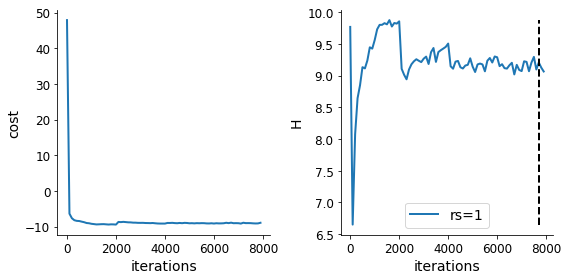

-3.5922668600243988 6.564132595875833
-1.7114801296327418 10.237748077422374
-15.846266953445031 33.500781065822046
-10.889363449947231 54.590706323819894


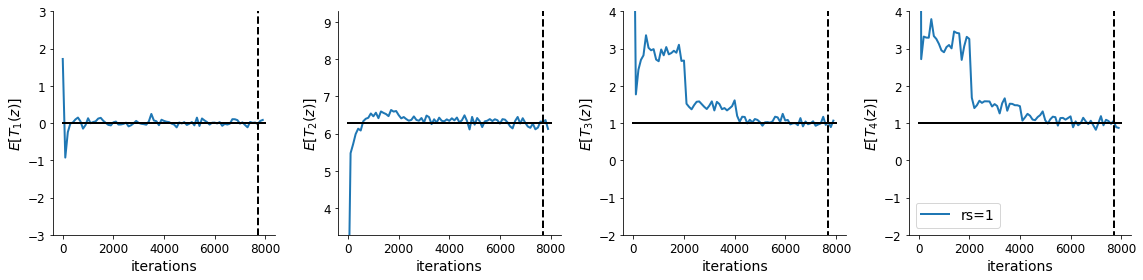

In [8]:

sysname = "Linear2D"
param_dict = {'omega':omega}
system = get_system_from_template(sysname, param_dict)


arch_params = {
               'D':system.D,
               'repeats':repeats,
               'nlayers':nlayers,
               'sigma_init':sigma_init,
              }
param_dict.update(arch_params)
arch_dict = get_arch_from_template(sysname, param_dict)

dir_str = 'LDS_test/'

model_dirs = [];
legendstrs = [];
for rs in range(start_rs, start_rs+num_rs):
    savedir = get_savedir(system, arch_dict, c_init, rs, dir_str)
    model_dirs.append(savedir)
    legendstr = 'rs=%d' % rs;
    legendstrs.append(legendstr);
    
figs, ME_its = plot_opt(model_dirs, legendstrs, frac_samps=0.5);

In [9]:
print(ME_its)

[array(77)]


0
dist (1000, 4)
log_q_z


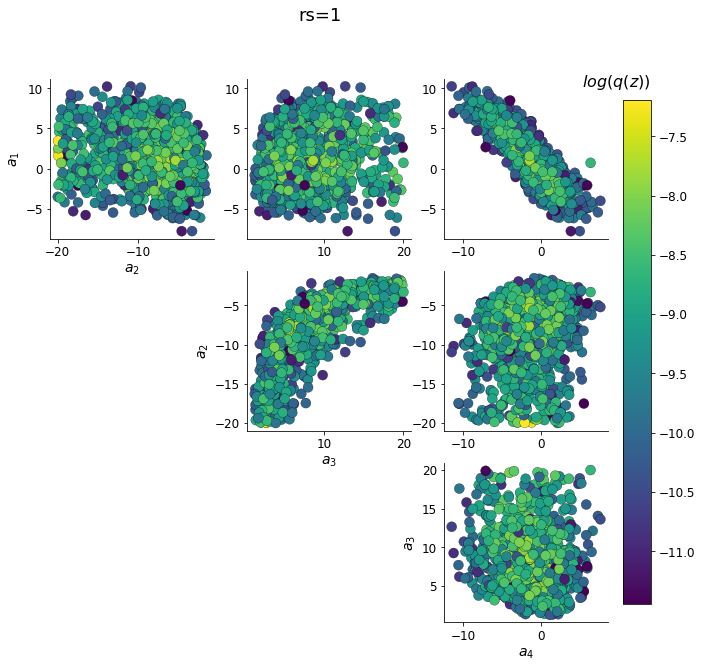

In [10]:
Zs, log_q_zs, axs = dsn_pairplots(model_dirs, 'Zs', system, system.D, f_str='identity', \
                                  c_str='log_q_z', legendstrs=legendstrs, AL_final_its=ME_its, \
                                  fontsize=14, ellipses=False, tri=True)

0
dist (1000, 4)
log_q_z


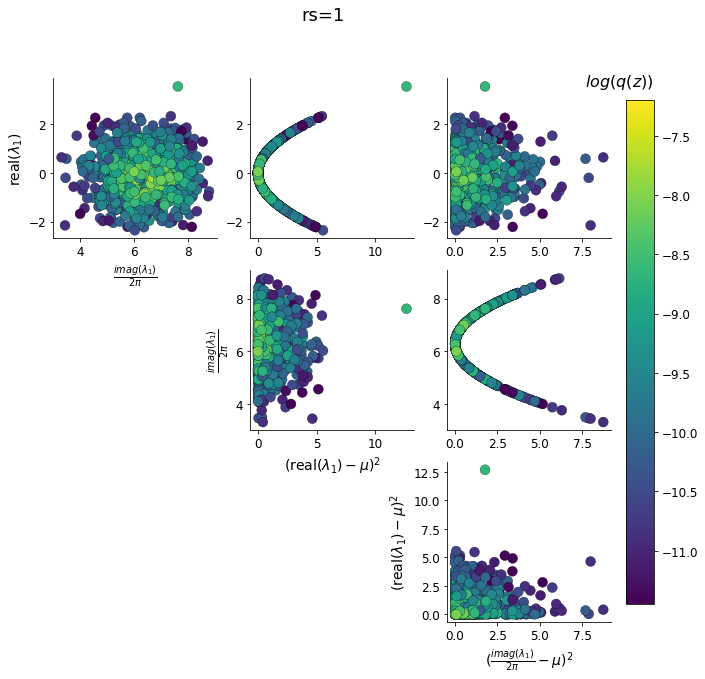

In [11]:
T_xs = dsn_pairplots(model_dirs, 'T_xs', system, system.num_suff_stats, f_str='identity', \
              c_str='log_q_z', legendstrs=legendstrs, AL_final_its=ME_its, \
              fontsize=14, ellipses=False, tri=True)

In [12]:
batch_norm = True

In [13]:
Ws_tf = []
Zs_tf = []
Z_INVs_tf = []
log_q_zs_tf = []

sessions = []
tf_vars = []
feed_dicts = []

M = 1000
_W = np.random.normal(0.0, 1.0, (1, M, 4))

for i in range(len(model_dirs)):
    model_dir = model_dirs[i]
    ME_it = ME_its[i]
    sess = tf.Session()
            
    collection = load_dgm(sess, model_dir, ME_it)
    W, Z, log_q_Z, Z_INV, batch_norm_mus, batch_norm_sigmas, batch_norm_layer_means, batch_norm_layer_vars = collection
    feed_dict = {W:_W}
    
    num_batch_norms = len(batch_norm_mus)
    
    """_batch_norm_mus, _batch_norm_sigmas = init_batch_norms(sess,
                                                           feed_dict, 
                                                           batch_norm_mus, 
                                                           batch_norm_sigmas, 
                                                           batch_norm_layer_means, 
                                                           batch_norm_layer_vars)"""
    
    param_fname = model_dir + 'params.npz' % ME_it
    paramfile = np.load(param_fname)
    _batch_norm_mus = paramfile['batch_norm_mus'][ME_it]
    _batch_norm_sigmas = paramfile['batch_norm_sigmas'][ME_it]
        
    for j in range(num_batch_norms):
        feed_dict.update({batch_norm_mus[j]:_batch_norm_mus[j]})
        feed_dict.update({batch_norm_sigmas[j]:_batch_norm_sigmas[j]})
                    
    _Z, _Z_INV, _log_q_z = sess.run([Z, Z_INV, log_q_Z], feed_dict)
    
    Ws_tf.append(_W)
    Zs_tf.append(_Z)
    Z_INVs_tf.append(Z_INV)
    log_q_zs_tf.append(_log_q_z)
    
    sessions.append(sess)
    tf_vars.append([W, Z, Z_INV, log_q_Z, batch_norm_mus, batch_norm_sigmas])
    feed_dicts.append(feed_dict)
    
    _Z_INV, _Z, _log_q_z, _batch_norm_layer_means, _batch_norm_layer_vars = sess.run([Z_INV, Z, log_q_Z, batch_norm_layer_means, batch_norm_layer_vars], feed_dict)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from models/LDS_test//Linear2D_A_oscillation_mu=0.00E+00_6.28E+00_1.00E+00_1.00E+00_flow=1R_4M_2L_10U_M_A_sigma=3.00_c=-1_rs=1/model-77


calc hess
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
done
0 run hess
done
d [-1.64725828 -0.84444904 -1.01846443 -0.0322631 ]
(1, 1000, 4)


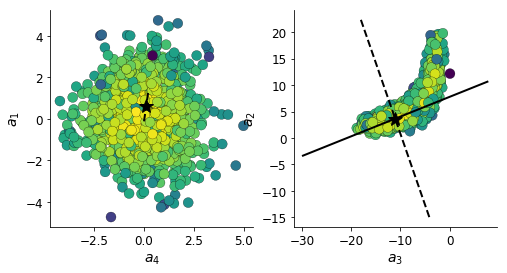

50 run hess
done
d [-1.52698736 -0.78307864 -0.83865661  0.0723238 ]
(1, 1000, 4)


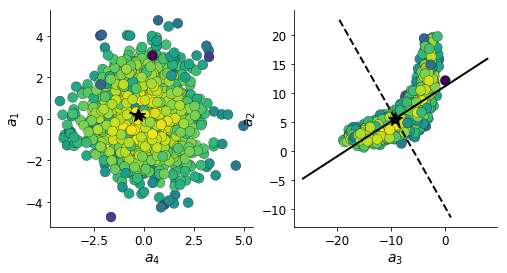

100 run hess
done
d [-0.12108865 -0.8036959  -0.98338257 -1.20149485]
(1, 1000, 4)


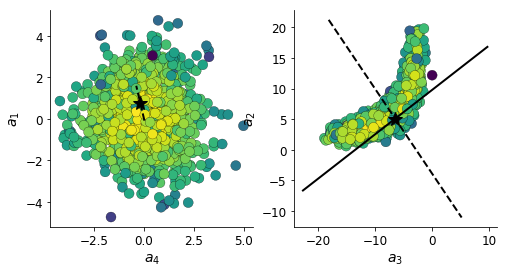

150 run hess
done
d [-1.26885375 -0.86712832 -0.94121351 -0.12829799]
(1, 1000, 4)


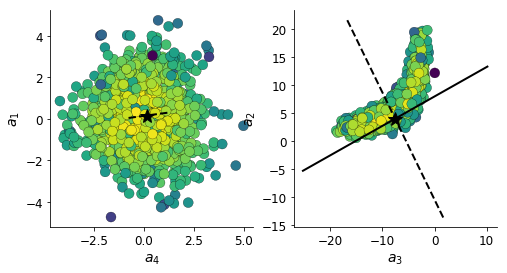

200 run hess
done
d [-1.87742032 -1.28563454 -0.86497934 -0.02436752]
(1, 1000, 4)


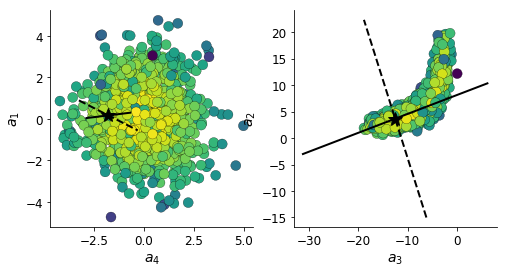

In [18]:
plot_inds = [0, 50, 100, 150, 200]
xlabels = [r'$a_4$', r'$a_3$']
ylabels = [r'$a_1$', r'$a_2$']
for k in range(len(model_dirs)):
    _W = Ws_tf[k]
    _Z = Zs_tf[k]
    _Z_INV = Z_INVs_tf[k]
    _log_q_z = log_q_zs_tf[k]
    
    sess = sessions[k]
    W, Z, Z_INV, log_q_Z, batch_norm_mus, batch_norm_sigmas = tf_vars[k]
    feed_dict = feed_dicts[k]
    
    print('calc hess')
    d2ldw2, d2wdz2, H = dgm_hessian(log_q_Z, W, Z, Z_INV)
    print('done')
    
    for plot_ind in plot_inds:
        z_max_inds = np.argsort(-_log_q_z[0,:])
        z_max_ind = z_max_inds[plot_ind]
        z_max = _Z[0,z_max_ind]
        w_max = np.expand_dims(_W[:,z_max_ind,:], 1)
        feed_dict.update({W:w_max})
        print(plot_ind, 'run hess')
        _H = sess.run(H, feed_dict)
        print('done')

        d, v = np.linalg.eig(_H)
        print('d', d)
        print(_Z.shape)

        I_inds = np.argsort(-np.abs(d))
        scale = 1.0

        vs = []
        ds = []
        for i in range(system.D):
            vs.append(v[:,I_inds[i]])
            ds.append(d[I_inds[i]])

        scale = 0.1

        fontsize = 14


        x_inds = [3, 2]
        y_inds = [0, 1]

        num_plts = len(x_inds)
        fig, axs = plt.subplots(1,num_plts,figsize=(8,4))
        scale_vs = [10.0, 20.0]
        for i in range(num_plts):
            scale_v = scale_vs[i]
            x_ind = x_inds[i]
            y_ind = y_inds[i]

            axs[i].scatter(_Z[0,:,x_ind], _Z[0,:,y_ind], c=_log_q_z[0,:], 
                           edgecolors="k", linewidths=0.25)
            axs[i].plot(_Z[0,z_max_ind,x_ind], _Z[0,z_max_ind,y_ind], 'k*', markersize=15)

            # show greatest eig
            min_len = 5.0
            #scale_v = max(scale*(1.0 / np.abs(ds[0])), min_len)
            vx = [_Z[0,z_max_ind,x_ind] - scale_v*vs[0][x_ind], 
                  _Z[0,z_max_ind,x_ind] + scale_v*vs[0][x_ind]]
            vy = [_Z[0,z_max_ind,y_ind] - scale_v*vs[0][y_ind], 
                  _Z[0,z_max_ind,y_ind] + scale_v*vs[0][y_ind]]
            axs[i].plot(vx, vy, 'k--')

            # show least eig
            #  = max(scale*(1.0 / np.abs(ds[-1])), min_len)
            vx = [_Z[0,z_max_ind,x_ind] - scale_v*vs[-1][x_ind], 
                  _Z[0,z_max_ind,x_ind] + scale_v*vs[-1][x_ind]]
            vy = [_Z[0,z_max_ind,y_ind] - scale_v*vs[-1][y_ind], 
                  _Z[0,z_max_ind,y_ind] + scale_v*vs[-1][y_ind]]
            axs[i].plot(vx, vy, 'k-')

            axs[i].set_xlabel(xlabels[i], fontsize=fontsize)
            axs[i].set_ylabel(ylabels[i], fontsize=fontsize)

            axs[i].spines['top'].set_visible(False)
            axs[i].spines['right'].set_visible(False)

        plt.show()